<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Первичный-анализ" data-toc-modified-id="Первичный-анализ-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Первичный анализ</a></span></li><li><span><a href="#Подготовим-данные-для-обучения" data-toc-modified-id="Подготовим-данные-для-обучения-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовим данные для обучения</a></span><ul class="toc-item"><li><span><a href="#Подготовим-таргет" data-toc-modified-id="Подготовим-таргет-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовим таргет</a></span></li><li><span><a href="#Подготовим-тренировочны-датасет" data-toc-modified-id="Подготовим-тренировочны-датасет-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Подготовим тренировочны датасет</a></span><ul class="toc-item"><li><span><a href="#Соединим-датафреймы-и-добавим-таргет." data-toc-modified-id="Соединим-датафреймы-и-добавим-таргет.-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Соединим датафреймы и добавим таргет.</a></span></li><li><span><a href="#Проверим-дубликаты" data-toc-modified-id="Проверим-дубликаты-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Проверим дубликаты</a></span></li><li><span><a href="#Очистим-текст" data-toc-modified-id="Очистим-текст-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Очистим текст</a></span></li><li><span><a href="#Разделим-выборку-на-тренировочную-и-валидационную" data-toc-modified-id="Разделим-выборку-на-тренировочную-и-валидационную-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Разделим выборку на тренировочную и валидационную</a></span></li></ul></li></ul></li><li><span><a href="#Подготовим-необходимые-классы-и-функции-для-обучения" data-toc-modified-id="Подготовим-необходимые-классы-и-функции-для-обучения-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовим необходимые классы и функции для обучения</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#CNN" data-toc-modified-id="CNN-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>CNN</a></span></li><li><span><a href="#Bidirectional-LSTM" data-toc-modified-id="Bidirectional-LSTM-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Bidirectional LSTM</a></span></li><li><span><a href="#LSTM-+-PackedSequence" data-toc-modified-id="LSTM-+-PackedSequence-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LSTM + PackedSequence</a></span></li></ul></li><li><span><a href="#Transformers-+-Bert" data-toc-modified-id="Transformers-+-Bert-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Transformers + Bert</a></span></li><li><span><a href="#Итог" data-toc-modified-id="Итог-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итог</a></span></li></ul></div>

# Бинарная классификация задач Kuzovkin.info

In [58]:
# подгружаем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import spacy
import nltk
import unicodedata
import contractions
import inflect
#import optuna
import torch
import time

from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from wordcloud import WordCloud
#from optuna.samplers import TPESampler
from transformers import AutoTokenizer, AutoModelForMaskedLM #AutoModel 
#from catboost import CatBoostClassifier
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchtext.vocab import build_vocab_from_iterator


nltk.download('stopwords') # поддерживает удаление стоп-слов
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CPU" device.


[nltk_data] Downloading package stopwords to /Users/tanya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
# константы
SEED = 42

model_name = 'cointegrated/LaBSE-en-ru'  # веса для обучения Bert
df_task = '/Users/tanya/Documents/DS/Projects/Kuzovkin_info/data-1719430924811.csv' # путь в файлу с текстом задач
df_topics = '/Users/tanya/Documents/DS/Projects/Kuzovkin_info/topics.csv' # путь к файлу со списком тем 
bert_embeddings = '/Users/tanya/Documents/DS/Projects/Kuzovkin_info/bert_embeddings.csv' # путь к эмбеддингам

## Первичный анализ

In [79]:
# датасет с задачами

try:
    df_task = pd.read_csv(df_task)
except Exception as ex: 
    print(ex)    

In [80]:
# датасет с иерархическим спиком

try:
    df_topics = pd.read_csv(df_topics)
except Exception as ex: 
    print(ex)

In [81]:
def df_info(data):
    
    '''
    Функция для первичного изучения] датасета. Нав вход принимает сам датасет, 
    на выход получаем общую информацитю о датасете.
    '''
    
    display(data.sample(10))
    display(data.info())
    print(data.duplicated().sum())
    print('Количество записпей: ', data.shape[0], 'Количество столбцов: ', data.shape[1])

In [82]:
df_info(df_task) # общая информация о датасете с текстом задач

,id,task,answer,topics_id,text_of_solution
29079,38810,"Известно, что \(\Delta АВС = \Delta А_{1}В_{1}С_{1}\). Точки \(D\) и \(Е\) - середины сто­рон \(АВ\) и \(ВС\), а точки \(D_{1}\) и \(E_{1}\) - середины сторон \(А_{1}В_{1}\) и \(B_{1}C_{1}\) соответственно. Докажите, что \(DЕ = D_{1}E_{1}\).",NaN,160,NaN
12553,15142,"Найдите наиболее рациональным способом значение выражения: ')0,6^{6} \cdot 5^{6}\)",729,121,"\(0,6^{6} \cdot 5,6^{6} = (\frac{3}{5} \cdot 5)^{6} = 3^{6} = 729\)"
15682,28326,"Нагрузка с сопротивлением \(R\), подключена к двум параллельно включенным батареям. Батареи имеют ЭДС \(E_{1}\) и \(E_{2}\) и внутренние сопротивления \(r_{1}\) и \(r_{2}\). Определить токи, идущие через сопротивления \(r_{1}\), \(r_{2}\), \(R\) и параметры (ЭДС и внутреннее сопротивление) источника, на который можно заменить батареи без изменения тока на нагрузке.",NaN,389,"Ток через нагрузку I = E/R0, токи через батареи и параметры эквивалентного источника при соединении одноименных клемм батарей: \(I_{1}=\frac{|E_{1}(r_{2}+R)|}{(r_{1}+r_{2})R_{0}}\), \(I_{2}=\frac{|E_{2}(r_{1}+R)|}{(r_{1}+r_{2})R_{0}}\), \(E=\frac{E_{1}r_{2}+E_{2}r_{1}}{r_{1}+r_{2}}\), \(r=\frac{r_{1}r_{2}}{r_{1}+r_{2}}\), где \(R_{0}=r+R\); токи через батареи и параметры эквивалентного о источника при соединении разноименных клемм батарей: \(I_{1}=\frac{E_{1}(r_{2}+R)+E_{2}R}{R_{0}(r_{1}+r_{2})}\), \(I_{2}=\frac{E_{2}(r_{1}+R)+E_{1}R}{R_{0}(r_{1}+r_{2})}\), \(E=\frac{E_{1}r_{2}-E_{2}r_{1}}{r_{1}+r_{2}}\), \(r=\frac{r_{1}r_{2}}{r_{1}+r_{2}}\), где \(R_{0}=r+R\)"
29746,43108,"Вычислите скорость изменения функции в точке \(x_0\): \(y=\sqrt{4x^2-20x+25}\),\(x_0=3\).",2,104,NaN
18882,40362,"Расположите в системе координат пря­моугольную трапецию с основаниями \(a\) и \(b\) (\(a < b\)) и высотой \(h\) так, чтобы две стороны трапеции лежали на осях координат. Определите координаты вершин трапеции.",NaN,502,NaN
29866,43477,"Используя данные о производной \(y=f'(x)\), приведенные в таблице, укажите: точки максимума функции\(y=f(x)\).<br> <img src='https://hot_data_kuzovkin_info_private.hb.ru-msk.vkcs.cloud/picture_to_tasks/math/mordkovich_10_11/рисунок: таблица 1.png'>",NaN,111,NaN
29013,38611,"Стороны \(АЕ\) и \(ВС\) выпуклого пятиугольника \(ABCDE\), вписанного в окружность, параллельны. Прямые \(ВС\) и \(DE\) пересекаются в точке \(К\). Докажите, что \(DK \cdot DA = DC \cdot DB\).",Утверджение доказано.,505,"Рассмотрите точку \(L\), в которой пересенаются прямые \(АЕ\) и \(CD\). Пусть градусные меры дуг \(ВС\), \(CD\), \(DE\) и \(EA\) равны \(2\alpha_{1}\), (2\alpha_{2}\), (2\beta_{2}\) и (2\beta_{1}\) (Рис. 259). Тогда \(\angle DAB = \alpha_{1} + \alpha_{2}\). Градусная мера дуги \(АВ\) равна 2(\alpha_{2} + \beta_{2})\), поэтому \(\angle DCK = \angle DLE = 2(\alpha_{w} + \beta_{2}) + 2\alpha_{2} - 2\beta_{2} = \angle DAB\). Аналогично \(\angle DEL = \angle DBA\). Следовательно, \(\Delta DAB \backsim \Delta DCK\)."
37018,29556,"В результате трения о шелк стеклянной палочке был сообщен положительный заряд. Все ли атомы, из которых состоит заряженная стеклянная палочка, нейтральны? Изменилась ли масса стеклянной палочки после сообщения ей положительного заряда? Обоснуйте свой ответ.",NaN,400,NaN
41980,49870,"На ребрах \(CD\) и \(DD_{1}\) куба \(ABCDA_{1}B_{1}C_{1}D_{1}\) взяты соответственно точки \(P\) и \(D_{2}\) - середины этих ребер. Постройте развертки многогранников \(U\left ( C \right )\), отсеченных от куба плоскостями, перпендикулярными прямой \(A_{1}C\) и проходящими через следующие точки: а)\(C_{1}\); б)\(P\); в)\(D_{2}\). Склейте модели многогранников \(U\left ( C \right )\).",NaN,653,NaN
30069,44169,"Докажите, что плоскость, проходящая через середины ребер \(AB\),\(AC\) и \(AD\) тетраэдра \(ABCD\), параллельна плоскости \(BCD\).",NaN,567,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42648 entries, 0 to 42647
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                42648 non-null  int64 
 1   task              42648 non-null  object
 2   answer            24048 non-null  object
 3   topics_id         42648 non-null  int64 
 4   text_of_solution  22678 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


None

0
Количество записпей:  42648 Количество столбцов:  5


In [83]:
df_info(df_topics) # общая информация о датасете со списком тем

,id,name,parent
79,80,Квадратный корень из двучлена вида A±√B. Формула сложного радикала,70
418,419,масса. плотность,418
394,395,Удельное сопротивление проводника,385
261,262,Решение тригонометрических неравенств,256
135,136,Куб суммы и куб разности,128
630,631,теорема Менелая,485
429,430,системы логарифмических неравенств,425
531,532,Простейшие задачи в координатах,502
47,48,Метод математической индукции,46
626,627,Параллельность прямых в пространстве,564


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      688 non-null    int64 
 1   name    688 non-null    object
 2   parent  688 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 16.2+ KB


None

0
Количество записпей:  688 Количество столбцов:  3


__Вывод:__

1) В df_task есть значительное количество пропусков в колонках answer и text_of_solution. Так как достоверно восстановить мы их не можем, нам придется удалить эти признаки.

2) Сами тексты задач имеют специфическе символы (формулы, обозначения), русские и английские буквы. Необходимо подобрать такую модель трансформера, которая учитывала бы эти особенности.

3) В df_topics у нас иерархический список, где у каждой темы есть id родителя. Необходимо разделить все темы на два класса Математика и Физика.

## Подготовим данные для обучения

### Подготовим таргет

In [84]:
# рекурсионная функция для классификации задач

def get_parent_id(idx):
    
    '''
    Функция на вход принимает индекс задачи, для которой нужно искать родителя. 
    На выходе получаем имя верхнегг родителя 
    '''
    
    row = df_topics.loc[df_topics.id == idx, :]
    parent, name = row['parent'].values[0], row['name'].values[0]
    if parent == 0:
        return name
    return get_parent_id(parent)

def label_rows(df_topics):
    
    '''
    Функция принимает на вход весь датафрейм.
    На выходе получаем датафрейм с новой колонкой, где записаны родители верхнего уровня.
    '''
    
    df_to_label = df_topics[df_topics['parent'] != 0]
    for i in df_to_label['id'].unique():
        name = get_parent_id(i)
        df_topics.loc[df_topics.id == i, 'subject'] = name
    df_topics.loc[df_topics.subject.isna(), 'subject'] = df_topics.loc[df_topics.subject.isna(), 'name'].values
    return df_topics

In [85]:
# применяем рекурсивнную функцию
label_rows(df_topics)

,id,name,parent,subject
0,1,Математика,0,Математика
1,2,Арифметика и начала Алгебры,1,Математика
2,3,Арифметика,2,Математика
3,4,Натуральные числа,3,Математика
4,5,Cложение и вычитание натуральных чисел,4,Математика
...,...,...,...,...
683,684,теорема Пуассона,560,Математика
684,685,Первоначальные понятия математической статистики,560,Математика
685,686,Оценка вероятности по относительной частоте. Доверительный интервал,685,Математика
686,687,Оценка параметров в статистике,685,Математика


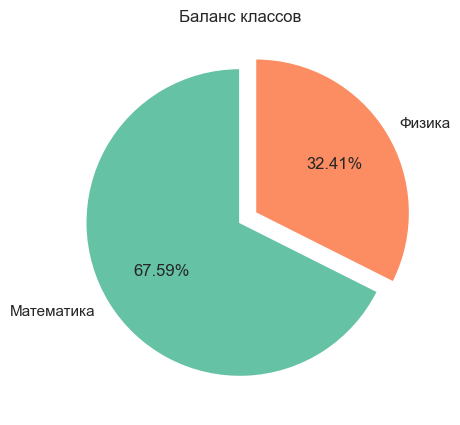

In [86]:
# граффик баланса классов
topics_counts = df_topics['subject'].value_counts()
labels=topics_counts.index
sns.set(font_scale = 1)
plt.figure(figsize=(5,5))

plt.pie(
    x=topics_counts, 
    labels=topics_counts.index,
    autopct='%1.2f%%',
    colors=sns.color_palette('Set2'),
    startangle=90,
    explode=[0, 0.12]
)
plt.title('Баланс класcов')
plt.show()

__Вывод:__ Задач по математики а два раза больше, зем задач по физике.

### Подготовим тренировочны датасет

#### Соединим датафреймы и добавим таргет.

In [87]:
df_info(df_task)

,id,task,answer,topics_id,text_of_solution
20218,46992,Постройте график функции: \(y=cos(x+\frac{\pi}{6})\).,NaN,87,NaN
17607,35921,"По бизнес-плану предполагается вложить в четырёхлетний проект 20 млн рублей. По итогам каждого года планируется прирост вложенных средств на 13% по сравнению с началом года. Начисленные проценты остаются вложенными в проект. Кроме этого, сразу после начислений процентов нужны дополнительные вложения: целое число \(n\) млн рублей в первый и второй годы, а также целое число \(m\) млн рублей третий и четвёртый годы. Найдите наименьшие значения \(n\) и \(m\), при которых первоначальные вложения за два года как минимум удвоятся, а за четыре года как минимум утроятся.",7 и 4,475,7 и 4
18693,39649,"Отрезок, концы которого лежат на боковых сторонах трапеции, параллелен ее основаниям и проходит через точку пересечения диагоналей.\nНайдите длину этого отрезка, если основания трапеции равны \(a\) и \(b\).",\(\fraq{2ab}{a + b}\).,517,"Рассмотрим \(\Delta ВОС\) и \(\Delta DОА\): \(\angle BOC = \angle AOD\) как вертикальные; \(\angle BCO = \angle DAO\) как внутренние накрест лежащие при \(BC \parallel AD\) и секущей \(AС \Rightarrow \Delta ВОС \sim \Delta DOA\) по двум углам.\nИз подобия следует: \(\fraq{BC}{AD} = \fraq{OC}{AO} = \fraq{BO}{OD} = \fraq{a}{2} \Rightarrow BO = \fraq{a \cdot OD}{b}\); \(CO = \fraq{AO \cdot a}{b}\), тогда \(BD = BO + OD = \fraq{(a + b) \cdot OD}{b}\), \(AC = AO + OC = \fraq{(a + b) \cdot AO}{b}\). Рассмотрим \(\Delta DOF\) и \(\Delta DBC\): \(\angle D\) - общий; \(\angle DOF = \angle DBC\) - как соответственные при \(BC \parallel EF\) и секущей \(BD \Rightarrow \Delta DOF \sim \Delta DBC\) по двум углам.\nИз подобия треугельников следует: \(\fraq{DO}{BD} = \fraq{OF}{BC} \Rightarrow OF = \fraq{DO \cdot BC}{BD} = \fraq{DO \cdot a \cdot b}{(a + b) \cdot DO} = \fraq{ab}{a + b}\). Аналогично доказывается, что \(\Delta АОЕ \sim \Delta АСВ \Rightarrow \fraq{AO}{AC} = \fraq{OE}{BC} \Rightarrow OE = \fraq{AO \cdot BC}{AC} = \fraq{AO \cdot a \cdot b}{(a + b) \cdot AO} = \fraq{ab}{a + b}\), \(FE = 2OE = \fraq{2ab}{a + b}\)."
32792,7353,"Известно, что последовательности \(\left \{ x_{n} \right \}\) и \(\left \{ y_{n} \right \} \)являются неограниченными. Выясните, является ли последовательность \(\left \{ z_{n} \right \}\) и,обязательно ограниченной,может ли она быть неограниченной, или всегда является ограниченной (если последовательность \(\left \{ z_{n} \right \}\) существует):\(z_{n}=x_{n}-y_{n} \)",NaN,55,"Так как последовательности \(\left \{ x_{n} \right \}\) и \(\left \{ y_{n} \right \}\)ограничены, существуют такие числа A и B, что \(\forall n\in N \left ( \left | x_{n} \right |\leqslant A \right )\wedge \left ( \left | y_{n} \right |\leqslant B \right ) \) \nНеравенства \(\left | x_{n}-y_{n} \right |\leqslant \left | x_{n} \right |+\left | y_{n} \right |\leqslant A+B\) показывают, что последовательность \(z_{n}=x_{n}+y_{n}\) обязательно ограничена."
11679,7156,Найти производные\(f(x)=\sqrt{2x-1}\),\(f^{'}(x)=\frac{1}{\sqrt{2x-1}}\),105,NaN
31107,48510,"На продолжнении стороны \(AC \Delta ABC\) за точку \(C\) взяли точку \(M\) так, что \(CM : AC = 4 : 5\). Через точку \(M\) провели прямую, которая делит стороны \(AB и BC \Delta\) в одинаковом отношении. Найдите это отношение.",NaN,631,NaN
22569,12067,Упростите выражение: \(\frac{6x^{2}-15x+25}{4x^{2}-25}+\frac{x}{5-2x}\),\(\frac{2x-5}{2x+5}\),85,\(\frac{6x^{2}-15x+25}{4x^{2}-25}+\frac{x}{5-2x}=\frac{6x^{2}-15x+25}{(2x-5)(2x+5)}-\frac{x}{2x-5}=\frac{6x^{2}-15x+25-x(2x+5)}{(2x-5)(2x+5)}=\frac{6x^{2}-15x+25-2x^{2}-5x}{(2x5)(2x+5)}=\frac{4x^{2}-20x+25}{(2x-5)(2x+5)}=\frac{(2x-5)^{2}}{(2x-5)(2x+5)}=\frac{2x-5}{2x+5}\)
37366,31029,"Возьмите большую кастрюлю с водой. Поместите в нее маленькую кастрюльку с водой так, чтобы она плавала, не касаясь дна большой кастрюли. Поставьте их на плиту и начните нагревать. Что будет с водой в маленькой кастрюле во время кипения воды в большой кастрюле? Почему? Бросьте в большую кастрюлю горсть соли. Что п

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42648 entries, 0 to 42647
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                42648 non-null  int64 
 1   task              42648 non-null  object
 2   answer            24048 non-null  object
 3   topics_id         42648 non-null  int64 
 4   text_of_solution  22678 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


None

0
Количество записпей:  42648 Количество столбцов:  5


In [88]:
# соединим два датафрейма

df_train = df_topics.merge(df_task, left_on='id', right_on='topics_id')

# уберем лишник колонки

df_train.drop(['id_x', 'name', 'parent', 'id_y', 'answer', 'topics_id', 'text_of_solution'],
              axis=1,
              inplace=True)

In [89]:
def make_target(row):
    
    '''
    Функция для определения таргета. На вход получает сам датафрейм. 
    На выходе, столбец с таргетом. 
    Математика - таргет 1. Физика - таргет 0. 
    '''
    
    try:
        if row.subject == 'Математика':
            return 1
        else:
            return 0
    except:
        pass

In [90]:
# применим функцию по добавлению таргета
df_train['target'] = df_train.apply(make_target, axis='columns')

#### Проверим дубликаты

In [91]:
# количество дубликатов в данных
df_train.duplicated().sum()

# удалим дубликаты
df_train.drop_duplicates(inplace=True)

In [92]:
df_train.head()

,subject,task,target
0,Математика,Равносильны ли уравнения: \(cosx=0\) и \(sin^2x=1\).,1
1,Математика,Равносильны ли уравнения: \(\frac{log_x(x+1)}{log_x2}=1\) и \(log_2(x+1)=1\).,1
2,Математика,Равносильны ли уравнения: \(\frac{x+3}{x+3}=1\) и \(\frac{x^2+3}{x^2+3}=1\).,1
3,Математика,Равносильны ли уравнения: \(log_{x^2}x^2=1 \) и \(log_xx=1\) .,1
4,Математика,Какое из двух уравнений является следствием другого: \(x^2=25\) и \(x^2-\frac{1}{x+5}=25-\frac{1}{x+5}\).,1


#### Очистим текст

In [93]:
# Выполню очистку текста и лемматизирую его. 
disabled_pipes = ['parser', 'ner']
nlp = spacy.load('ru_core_news_sm', disable=disabled_pipes)


def clean_text(input_text):    
    
    '''
    Функция для очистки текста.
    На вход принимает текст задач. На выходе получаем очищенный текст 
    '''
    
    # HTML-теги: первый шаг - удалить из входного текста все HTML-теги
    clean_text = re.sub('<[^<]+?>', ' ', input_text)
    
    # URL и ссылки: далее - удаляем из текста все URL и ссылки
    clean_text = re.sub(r'http\S+', ' ', clean_text)

    
    # Приводим все входные данные к нижнему регистру
    clean_text = clean_text.lower()

    # Убираем все пробелы
    # Так как все данные теперь представлены словами - удалим пробелы
    clean_text = re.sub('\s+', ' ', clean_text)

    # Разворачиваем сокращения: текст часто содержит конструкции вроде "don't" или "won't", 
    #поэтому развернём подобные сокращения
    clean_text = contractions.fix(clean_text)

    
    # Убираем специальные символы: избавляемся от всего, что не является "словами"
    pattern = '[^а-яА-ЯёЁ0-9a-zA-Z\s]'
    clean_text = re.sub(pattern, ' ', clean_text)
    
    # Записываем числа прописью: 100 превращается в "сто" (для компьютера)
    temp = inflect.engine()
    words = []
    for word in clean_text.split():
        if word.isdigit():
            words.append(temp.number_to_words(word))
        else:
            words.append(word)
    clean_text = ' '.join(words)
    
    

    # Стоп-слова: удаление стоп-слов - это стандартная практика очистки текстов
    stop_words = set(stopwords.words('russian'))
    tokens = word_tokenize(clean_text, language='russian')
    tokens = [token for token in tokens if token not in stop_words]
    clean_text = ' '.join(tokens) 
   
    # Знаки препинания: далее - удаляем из текста все знаки препинания
    clean_text = re.sub(r'[^\w\s]', ' ', clean_text)
    
    # Удаляем пробелы
    clean_text = re.sub('\s+', ' ', clean_text).strip()

    # И наконец - возвращаем очищенный текст
    return clean_text


def lemmatization(text):

    '''
    Функция лемметезации текста
    На вход получает очищенный текст.
    На выходе лемметизированныцй текст
    '''
    
    if not isinstance(text, str):
        text = str(text)
    
    doc = nlp(text)

    return ' '.join([token.lemma_ for token in doc])

In [94]:
tqdm.pandas()
df_train['clean_text'] = df_train['task'].progress_apply(clean_text) # очистка текста для train

  0%|          | 0/39887 [00:00<?, ?it/s]

In [95]:
tqdm.pandas()
df_train['lemm_text'] = df_train['clean_text'].progress_apply(lemmatization) # лемм. текста для train

  0%|          | 0/39887 [00:00<?, ?it/s]

In [96]:
df_train.sample(5) #посмотрим что получилось

,subject,task,target,clean_text,lemm_text
21057,Физика,"Мягкая легкая металлическая пружина висит, погрузившись нижним концом в соленую воду на небольшую глубину (рисунок ниже). Что произойдет после замыкания ключа?<br> <img src='https://hot_data_kuzovkin_info_private.hb.bizmrg.com/picture_to_tasks/physics/gendenshtein_8/magnit_optika/105_gendenshteyn_96.png'>",0,мягкая легкая металлическая пружина висит погрузившись нижним концом соленую воду небольшую глубину рисунок ниже произойдет замыкания ключа,мягкий лёгкий металлический пружина висеть погрузившись нижний конец солёный вода небольшой глубина рисунок ниже произойти замыкание ключ
33061,Математика,"На рисунке ниже стрелочками отмечены параллельные прямые. На рисунке изображён параллелограмм. Найдите на рисунках ниже длину отрезка, обозначенного буквой \(х\).<br> <img src='https://hot_data_kuzovkin_info_private.hb.ru-msk.vkcs.cloud/picture_to_tasks/math/Volchkevich_mat_vertical_9/245.png'>",1,рисунке ниже стрелочками отмечены параллельные прямые рисунке изображён параллелограмм найдите рисунках ниже длину отрезка обозначенного буквой х,рисунке низкий стрелочка отметить параллельный прямой рисунке изображён параллелограмм найти рисунок ниже длина отрезка обозначенного буква х
12138,Математика,"Через данную точку внутри окружности проведите хорду, которая делится этой точкой пополам.",1,данную точку внутри окружности проведите хорду которая делится точкой пополам,данную точка внутри окружность проведите хорду которая делиться точка пополам
19025,Математика,Решите уравнение: \(cos^{2}x-3cosx+a=0\),1,решите уравнение cos two x 3cosx a zero,решить уравнение cos two x 3cosx a zero
19351,Математика,Решите уравнение: \(sin9x=2sin3x\),1,решите уравнение sin9x 2sin3x,решить уравнение sin9x 2sin3x


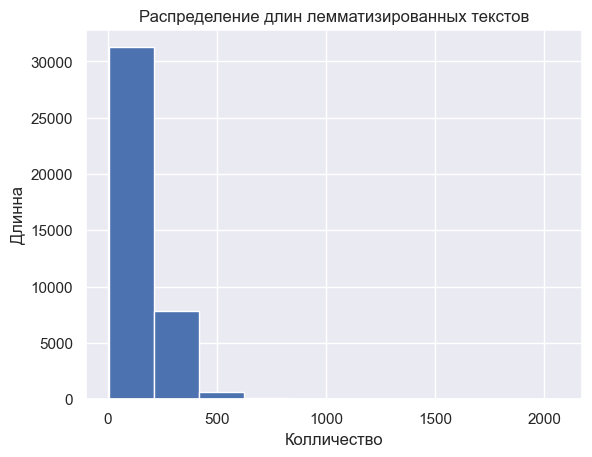

In [97]:
df_train['lemm_text'].str.len().hist()
plt.title('Распределение длин лемматизированных текстов')
plt.xlabel('Колличество')
plt.ylabel('Длинна')
plt.show()

In [98]:
# уберем все строки с нулевой длинной
df_train = df_train[~(df_train['lemm_text'].str.len() == 0)]

#### Разделим выборку на тренировочную и валидационную

In [100]:
# убираем лишние колонки
df_train_net = df_train.drop(['subject', 'task', 'clean_text'], axis=1)

In [24]:
# избавляемся от дубликатов
print(df_train_net.duplicated().sum())
df_train_net.drop_duplicates(inplace=True)

df_train_net.reset_index(drop=True, inplace=True) # перезапишем индексы

456


In [25]:
df_train_net.shape # посмотрим размерность

(39431, 2)

In [26]:
# разделим выборки на тренировочную, валидационную и тестовую
train, valid = train_test_split(df_train_net, 
                                test_size=0.25, 
                                random_state=SEED,
                                stratify=df_train['target'])

valid, test = train_test_split(valid, 
                                test_size=0.5, 
                                random_state=SEED,
                                stratify=valid['target'])

In [27]:
# перезапишем индексы
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [28]:
# проверим размерность полученых переменых
print(train.shape)
print(valid.shape)
print(test.shape)

(29573, 2)
(4929, 2)
(4929, 2)


## Подготовим необходимые классы и функции для обучения

In [29]:
# подберем веса классов
class_counts = train['target'].value_counts().to_list()
num_samples = sum(class_counts)
labels = train['target'].values - 1

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

In [30]:
# определие специальных символы и индексы
PAD_IDX, UNK_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

# токены должны быть расположены в порядке следования их индексов, чтобы правильно вставить их в словарь
special_symbols = ["<pad>", "<unk>", "<bos>", "<eos>"]

In [31]:
# сделаем класс для текстовых данных

class TextDataset(Dataset):
    def __init__(self, data, max_len=64):
        self.data = data
        self.max_len = max_len

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        row = self.data.iloc[ix].squeeze()
        text = row['lemm_text']
        label = row['target']
        
        return text, label

    def collate_fn(self, batch):
        texts, labels = list(zip(*batch))       
        text_batch = torch.zeros((len(texts), self.max_len)).fill_(PAD_IDX).long() # постоянная длинна
              
        for i in range(len(texts)):
            sample = text_transform(texts[i])[:self.max_len]
            text_batch[i, :len(sample)] = sample
        
        labels = torch.cat([torch.tensor(label).unsqueeze(0) for label in labels]).to(device)
        return text_batch.to(device), labels

In [37]:
token_transform = get_tokenizer('spacy', language='ru_core_news_sm') # токенизация текста

def yield_tokens(data_iter):
    
    '''
    Функция для преобразовать данные, содержащиеся в data_iter,
   с помощью функции token_transform.
   На вход получает итерируемый объект.
   На выходе возвращает преобразованные данные преобразованные данные.
    '''

    for data_sample in data_iter:
        yield token_transform(data_sample[0])    

In [38]:
# создадим объект Vocab для 
data_iter = TextDataset(df_train)

vocabulary = build_vocab_from_iterator(yield_tokens(data_iter),  # определяем набор данных
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Зададим `UNK_IDX` в качестве индекса по умолчанию. Этот индекс возвращается, когда токен не найден.
vocabulary.set_default_index(UNK_IDX)

In [39]:
def sequential_transforms(*transforms):
    
    '''
    функция для объединения последовательных операций
    '''
    
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def tensor_transform(token_ids, drop_specials=True):
    
    '''
    Функция для добавления BOS/EOS и создания тензора для индексов входной последовательности
    '''
    
    if drop_specials:
        return torch.tensor(token_ids)
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# трансформируем текст
text_transform = sequential_transforms(token_transform,  # токенизация
                                       vocabulary,       # нумиризация
                                       tensor_transform) # добавляем BOS/EOS и создаем тензор

In [40]:
# создадим загрузчики данных для тренировочной, валидационной и тестовой
train_ds = TextDataset(train)
valid_ds = TextDataset(valid)
test_ds = TextDataset(test)

train_dataloader = DataLoader(train_ds, batch_size=128, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dataloader = DataLoader(valid_ds, batch_size=128, collate_fn=valid_ds.collate_fn)
test_dataloader = DataLoader(test_ds, batch_size=64, collate_fn=test_ds.collate_fn)

In [41]:
# создадим класс ранней остановки

class EarlyStopping:
    
    # patience - количество эпох ожидания, прежде чем остановиться, если улучшения не будет
    # min_delta - Минимальное изменение контролируемого количества, которое можно квалифицировать как улучшение
    # counter - счетчик
    # best_loss - лучшее значение фуекции потерь
    # early_stop - ранняя остновка
    
    def __init__(self, patience=5, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            if model is not None:
                checkpoint = {
                    'model': model,
                }
                torch.save(checkpoint, self.path)
                print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

                
def calc_accuracy(y_pred, y_true):
    
    '''
    Функция расчета аccuracy. На вход получает предсказания модели и настоящие значения таргета
    На выходе значения метрики аccuracy 
    '''
    
    return (y_true == torch.max(y_pred, 1)[1]).float().mean()


class FocalLoss(nn.Module):
    
    ''' 
    https://github.com/AdeelH/pytorch-multi-class-focal-loss/blob/master/focal_loss.py
    
    Класс для устранения дисбаланса классов. Позволяет избежать потери энтропии и
    полезно для задач классификации при большом дисбалансе классов.
    Ожидается, что x будет содержать необработанные, ненормализованные оценки для каждого класса.
    Ожидается, что y будет содержать метки классов.
    
    Размерность:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    '''
    
    def __init__(self, *args, 
                 alpha: torch.Tensor = None, 
                 gamma: float = 2.0, 
                 reduction: str = 'mean',
                 ignore_index: int = -100,
                 **kwargs
                 ):
        
        '''        
            alpha (Tensor, optional): Веса каждого класса, по умолчанию None.
            gamma (float, optional): Константа, по умолчанию 2.0.                
            reduction (str, optional): 'mean', 'sum' or 'none'. Но умолчанию 'mean'.
            ignore_index (int, optional): Метка класса, которую следует ингнорировать. Но умолчанию -100.
        '''
        
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super(FocalLoss, self).__init__(*args, **kwargs)
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        if x.ndim > 2:
            c = x.shape[1]  
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            y = y.view(-1)  
        
        y = y.long()
        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.)
        x = x[unignored_mask]

        # вычислить взвешенный коэффициент перекрестной энтропии:
        # -alpha * log(pt) (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # получить столбец истинного класса из каждой строки
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # вычесляем focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # полная loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss

In [42]:
def train_one_batch(data, model, criterion, optimizer):
    
    '''
    Функция для тренироваки одного batch.
    На вход принимет данные, модель для обучения, функцию потерь и оптимизатор.
    На выходе значения функции потерь и accuracy.
    '''
    
    model.train()
    texts, labels = data
    optimizer.zero_grad()
    output = model(texts)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = calc_accuracy(output, labels)
    return loss.item(), accuracy.item()


@torch.no_grad()
def validate_one_batch(data, model, criterion):
    
    '''
    Функция для валидации одного batch.
    На вход принимет данные, модель для обучения, функцию потерь и оптимизатор.
    На выходе значения функции потерь и accuracy.
    '''
    
    model.eval()
    texts, labels = data
    
    out = model(texts)
    loss = criterion(out, labels)
    
    accuracy = calc_accuracy(out, labels)
    
    return loss.item(), accuracy.item()


In [43]:
def run(model, epochs=40, print_freq=50):
    
    '''
    Функция для обучения модели.
    На вход принимает содель для обучения, количество эпох, частоту вывачи информации о прогрессе обучения.
    На выходе значения функции потерь и accuracy для тренировочной, валидационной и тестовой выборках.
    '''

    for epoch in range(1, epochs+1):

        train_loss, train_accs = [], []
        for step, batch in enumerate(train_dataloader, 1):
            time_1 = time.time()

            loss, accuracy = train_one_batch(batch, model, criterion, optimizer)

            train_loss.append(loss)
            train_accs.append(accuracy)

            if step % print_freq == 0:
                print('epoch:', epoch, 
                      '\tstep:', step, '/', len(train_dataloader),
                      '\ttrain loss:', '{:.4f}'.format(loss),
                      '\ttrain accuracy:','{:.4f}'.format(accuracy),
                      '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')

        valid_loss, valid_accs = [], []
        for step, batch in enumerate(tqdm(valid_dataloader)):
            loss, accuracy = validate_one_batch(batch, model, criterion)

            valid_loss.append(loss)
            valid_accs.append(accuracy)

        print('epoch:', epoch, '/', epochs,
              '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
              '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
              '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
              '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))

        stopper(np.mean(valid_loss), model)
        if stopper.early_stop:
            checkpoint = torch.load("model.pth", map_location=device)
            model = checkpoint['model']
            break
        scheduler.step(np.mean(valid_loss))

    test_loss, test_accs = [], []
    for step, batch in enumerate(tqdm(test_dataloader)):
        loss, accuracy = validate_one_batch(batch, model, criterion)

        test_loss.append(loss)
        test_accs.append(accuracy)

    print('\ttest loss:', '{:.4f}'.format(np.mean(test_loss)),
          '\ttest accuracy', '{:.4f}'.format(np.mean(test_accs)),)

__Models:__

 - CNN
 - LSTM
 - LSTM-CNN
 - Transformer

## Обучение моделей

### CNN

In [47]:
class CNNModel(nn.Module):
    
    '''
    Задаем класс модели для обучения.
    На вход получает число скрытых слоев, размер словаря, коэффициент исключения нейронов, количество классов.
    '''
    
    def __init__(self, hidden_dim, vocab_size, num_classes=2, dropout=0.1, **kwargs):
        super(CNNModel ,self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)  #, padding_idx=PAD_IDX)  # default = 0
        self.conv1 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        
        self.cconv1 = nn.Conv1d(hidden_dim, hidden_dim//4, kernel_size=1, padding=0)
        self.cconv2 = nn.Conv1d(hidden_dim, hidden_dim//4, kernel_size=2, padding=1)
        self.cconv3 = nn.Conv1d(hidden_dim, hidden_dim//4, kernel_size=3, padding=1)
        self.cconv4 = nn.Conv1d(hidden_dim, hidden_dim//4, kernel_size=5, padding=2)
        self.cbatch = nn.BatchNorm1d(hidden_dim)
        
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(hidden_dim*2, hidden_dim*2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_dim*2, hidden_dim*4, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(hidden_dim*4, hidden_dim*4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        
        self.reducer = nn.Linear(hidden_dim*4, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.contiguous().permute(0,2,1)  # [B, SEQ_LEN, hidden] -> [B, hidden, SEQ_LEN] 
                                           # to slide over sequence for n-gramms        
        
        in_x1 = self.cconv1(x)
        in_x2 = self.cconv1(x)
        in_x3 = self.cconv1(x)
        in_x4 = self.cconv1(x)
        in_x = torch.cat([in_x1, in_x2, in_x3, in_x4], dim=1)
        # in_x = self.cbatch(x)
        in_x = F.relu(in_x)
        
        x = self.conv2(in_x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv5(x)
        x = F.relu(x)
        # x = self.pool(x)
        x = torch.max(x, dim=2)[0]  # obtain max n-gramm info
        # x = x.contiguous().view(x.size(0), -1)
        x = self.reducer(x)
        x = F.relu(x)
        
        x = self.dropout(x)
        x = self.fc(x)
        
        return x


In [45]:
model = CNNModel(hidden_dim=64, vocab_size=len(vocabulary), dropout=0.3, num_classes=2).to(device) # модель

criterion = nn.CrossEntropyLoss() # функция потерь

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0005) # оптимизатор

# автоматическое регулирование скорости обучения 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.1)

stopper = EarlyStopping(patience=4) # ранняя остановка

In [46]:
# запускаем модель 
run(model)

epoch: 1 	step: 50 / 232 	train loss: 0.2739 	train accuracy: 0.8906 	time: 8.3851 s
epoch: 1 	step: 100 / 232 	train loss: 0.1867 	train accuracy: 0.9141 	time: 10.0127 s
epoch: 1 	step: 150 / 232 	train loss: 0.1199 	train accuracy: 0.9766 	time: 8.0907 s
epoch: 1 	step: 200 / 232 	train loss: 0.0409 	train accuracy: 0.9922 	time: 8.5253 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 1 / 40 	train loss: 0.2273 	valid loss: 0.1470 	train accuracy 0.8960 	valid accuracy 0.9381
epoch: 2 	step: 50 / 232 	train loss: 0.0965 	train accuracy: 0.9609 	time: 8.1114 s
epoch: 2 	step: 100 / 232 	train loss: 0.0415 	train accuracy: 0.9844 	time: 8.0544 s
epoch: 2 	step: 150 / 232 	train loss: 0.0861 	train accuracy: 0.9688 	time: 8.1000 s
epoch: 2 	step: 200 / 232 	train loss: 0.0269 	train accuracy: 0.9922 	time: 8.4602 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 2 / 40 	train loss: 0.0720 	valid loss: 0.0609 	train accuracy 0.9752 	valid accuracy 0.9778
Model saved to: model.pth
epoch: 3 	step: 50 / 232 	train loss: 0.0845 	train accuracy: 0.9844 	time: 8.0164 s
epoch: 3 	step: 100 / 232 	train loss: 0.0434 	train accuracy: 0.9844 	time: 8.1047 s
epoch: 3 	step: 150 / 232 	train loss: 0.0427 	train accuracy: 0.9844 	time: 13.4734 s
epoch: 3 	step: 200 / 232 	train loss: 0.0443 	train accuracy: 0.9922 	time: 8.0641 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 3 / 40 	train loss: 0.0474 	valid loss: 0.0608 	train accuracy 0.9847 	valid accuracy 0.9788
Model saved to: model.pth
epoch: 4 	step: 50 / 232 	train loss: 0.0034 	train accuracy: 1.0000 	time: 8.0220 s
epoch: 4 	step: 100 / 232 	train loss: 0.0062 	train accuracy: 1.0000 	time: 8.1576 s
epoch: 4 	step: 150 / 232 	train loss: 0.0165 	train accuracy: 1.0000 	time: 8.3100 s
epoch: 4 	step: 200 / 232 	train loss: 0.0307 	train accuracy: 0.9844 	time: 8.0845 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 4 / 40 	train loss: 0.0293 	valid loss: 0.0520 	train accuracy 0.9905 	valid accuracy 0.9842
Model saved to: model.pth
epoch: 5 	step: 50 / 232 	train loss: 0.0086 	train accuracy: 1.0000 	time: 8.2265 s
epoch: 5 	step: 100 / 232 	train loss: 0.0271 	train accuracy: 0.9922 	time: 8.1987 s
epoch: 5 	step: 150 / 232 	train loss: 0.0061 	train accuracy: 1.0000 	time: 7.9541 s
epoch: 5 	step: 200 / 232 	train loss: 0.0219 	train accuracy: 0.9922 	time: 8.1095 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 5 / 40 	train loss: 0.0208 	valid loss: 0.0576 	train accuracy 0.9932 	valid accuracy 0.9806
INFO: Early stopping counter 1 of 4
epoch: 6 	step: 50 / 232 	train loss: 0.0083 	train accuracy: 0.9922 	time: 8.0800 s
epoch: 6 	step: 100 / 232 	train loss: 0.0030 	train accuracy: 1.0000 	time: 8.3175 s
epoch: 6 	step: 150 / 232 	train loss: 0.0252 	train accuracy: 0.9922 	time: 8.1200 s
epoch: 6 	step: 200 / 232 	train loss: 0.0028 	train accuracy: 1.0000 	time: 8.3788 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 6 / 40 	train loss: 0.0128 	valid loss: 0.0529 	train accuracy 0.9961 	valid accuracy 0.9846
INFO: Early stopping counter 2 of 4
epoch: 7 	step: 50 / 232 	train loss: 0.0393 	train accuracy: 0.9844 	time: 8.6201 s
epoch: 7 	step: 100 / 232 	train loss: 0.0152 	train accuracy: 0.9922 	time: 8.0534 s
epoch: 7 	step: 150 / 232 	train loss: 0.0174 	train accuracy: 0.9922 	time: 8.4396 s
epoch: 7 	step: 200 / 232 	train loss: 0.0170 	train accuracy: 0.9922 	time: 9.0165 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 7 / 40 	train loss: 0.0124 	valid loss: 0.0685 	train accuracy 0.9961 	valid accuracy 0.9820
INFO: Early stopping counter 3 of 4
epoch: 8 	step: 50 / 232 	train loss: 0.0030 	train accuracy: 1.0000 	time: 9.4079 s
epoch: 8 	step: 100 / 232 	train loss: 0.0013 	train accuracy: 1.0000 	time: 9.3728 s
epoch: 8 	step: 150 / 232 	train loss: 0.0007 	train accuracy: 1.0000 	time: 9.4807 s
epoch: 8 	step: 200 / 232 	train loss: 0.0186 	train accuracy: 0.9922 	time: 9.5103 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 8 / 40 	train loss: 0.0034 	valid loss: 0.0653 	train accuracy 0.9991 	valid accuracy 0.9848
INFO: Early stopping counter 4 of 4
INFO: Early stopping


  0%|          | 0/78 [00:00<?, ?it/s]

	test loss: 0.0569 	test accuracy 0.9824


In [172]:
cnn_accuracy = 0.9824

__Вывод:__ Модель с использованием свёрточной нейронной сети, показала метрику accuracy = 0.9824 на тестовой выборке.

### Bidirectional LSTM

In [50]:
class BiLSTM(nn.Module):
    
    '''
    Задаем класс модели для обучения.
    На вход получает число скрытых слоев, размер словаря, количество классов,
    коэффициент исключения нейронов, количество слоев LSTM.
    '''
    
    def __init__(self, hidden_dim, vocab_size, num_classes=2, dropout=0.1, num_layers=2, **kwargs):
        super(BiLSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(input_size=hidden_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=dropout,
                            bidirectional=True)
        self.dropout = nn.Dropout(p=dropout)
        self.fc_mid = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc_out = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        
        # содержит выходные обкекты (h_t) из последнего слоя LSTM, для каждого t: [B, SEQ, hidden * bidirect]
        x, _ = self.lstm(x)
        
        avg_pool = torch.mean(x, dim=1)
        max_pool = torch.max(x, dim=1)[0]
        
        x = torch.cat((avg_pool, max_pool), dim=1)
        
        x = F.relu(self.fc_mid(self.dropout(x)))

        x = self.fc_out(x)
        return x

In [51]:
model = BiLSTM(hidden_dim=64, vocab_size=len(vocabulary), dropout=0.3, num_layers=1).to(device) # модель

criterion = nn.CrossEntropyLoss() # функция потерь

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00005) # оптимизатор

# автоматическое регулирование скорости обучения
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5) 

stopper = EarlyStopping(patience=4) # ранняя остановка

In [52]:
run(model)

epoch: 1 	step: 50 / 232 	train loss: 0.6481 	train accuracy: 0.6016 	time: 6.1293 s
epoch: 1 	step: 100 / 232 	train loss: 0.5699 	train accuracy: 0.6875 	time: 6.5230 s
epoch: 1 	step: 150 / 232 	train loss: 0.5840 	train accuracy: 0.6953 	time: 10.6645 s
epoch: 1 	step: 200 / 232 	train loss: 0.4407 	train accuracy: 0.8047 	time: 8.6779 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 1 / 40 	train loss: 0.5603 	valid loss: 0.3800 	train accuracy 0.7084 	valid accuracy 0.8536
epoch: 2 	step: 50 / 232 	train loss: 0.2845 	train accuracy: 0.8984 	time: 9.7362 s
epoch: 2 	step: 100 / 232 	train loss: 0.2995 	train accuracy: 0.8906 	time: 7.3025 s
epoch: 2 	step: 150 / 232 	train loss: 0.2514 	train accuracy: 0.9062 	time: 10.0863 s
epoch: 2 	step: 200 / 232 	train loss: 0.2149 	train accuracy: 0.8906 	time: 6.3716 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 2 / 40 	train loss: 0.2573 	valid loss: 0.1719 	train accuracy 0.8970 	valid accuracy 0.9293
Model saved to: model.pth
epoch: 3 	step: 50 / 232 	train loss: 0.1225 	train accuracy: 0.9609 	time: 6.2846 s
epoch: 3 	step: 100 / 232 	train loss: 0.1408 	train accuracy: 0.9141 	time: 6.2048 s
epoch: 3 	step: 150 / 232 	train loss: 0.1131 	train accuracy: 0.9688 	time: 6.2351 s
epoch: 3 	step: 200 / 232 	train loss: 0.1274 	train accuracy: 0.9609 	time: 6.2526 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 3 / 40 	train loss: 0.1518 	valid loss: 0.1339 	train accuracy 0.9396 	valid accuracy 0.9485
Model saved to: model.pth
epoch: 4 	step: 50 / 232 	train loss: 0.1135 	train accuracy: 0.9453 	time: 6.7062 s
epoch: 4 	step: 100 / 232 	train loss: 0.1351 	train accuracy: 0.9609 	time: 6.3079 s
epoch: 4 	step: 150 / 232 	train loss: 0.0967 	train accuracy: 0.9766 	time: 7.6738 s
epoch: 4 	step: 200 / 232 	train loss: 0.0875 	train accuracy: 0.9609 	time: 6.3294 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 4 / 40 	train loss: 0.1158 	valid loss: 0.1089 	train accuracy 0.9548 	valid accuracy 0.9601
Model saved to: model.pth
epoch: 5 	step: 50 / 232 	train loss: 0.1179 	train accuracy: 0.9531 	time: 6.7875 s
epoch: 5 	step: 100 / 232 	train loss: 0.0642 	train accuracy: 0.9766 	time: 6.3470 s
epoch: 5 	step: 150 / 232 	train loss: 0.1051 	train accuracy: 0.9609 	time: 6.5678 s
epoch: 5 	step: 200 / 232 	train loss: 0.0233 	train accuracy: 1.0000 	time: 7.4911 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 5 / 40 	train loss: 0.0969 	valid loss: 0.0944 	train accuracy 0.9635 	valid accuracy 0.9651
Model saved to: model.pth
epoch: 6 	step: 50 / 232 	train loss: 0.0755 	train accuracy: 0.9688 	time: 6.4243 s
epoch: 6 	step: 100 / 232 	train loss: 0.0905 	train accuracy: 0.9688 	time: 6.7248 s
epoch: 6 	step: 150 / 232 	train loss: 0.0600 	train accuracy: 0.9766 	time: 6.4685 s
epoch: 6 	step: 200 / 232 	train loss: 0.0504 	train accuracy: 0.9922 	time: 6.2386 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 6 / 40 	train loss: 0.0827 	valid loss: 0.0896 	train accuracy 0.9690 	valid accuracy 0.9674
Model saved to: model.pth
epoch: 7 	step: 50 / 232 	train loss: 0.0359 	train accuracy: 0.9844 	time: 7.7824 s
epoch: 7 	step: 100 / 232 	train loss: 0.0397 	train accuracy: 0.9922 	time: 7.3106 s
epoch: 7 	step: 150 / 232 	train loss: 0.0811 	train accuracy: 0.9922 	time: 6.0833 s
epoch: 7 	step: 200 / 232 	train loss: 0.0561 	train accuracy: 0.9766 	time: 6.2173 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 7 / 40 	train loss: 0.0725 	valid loss: 0.0805 	train accuracy 0.9745 	valid accuracy 0.9730
Model saved to: model.pth
epoch: 8 	step: 50 / 232 	train loss: 0.0984 	train accuracy: 0.9688 	time: 8.6918 s
epoch: 8 	step: 100 / 232 	train loss: 0.0394 	train accuracy: 0.9766 	time: 8.5710 s
epoch: 8 	step: 150 / 232 	train loss: 0.1424 	train accuracy: 0.9531 	time: 6.2357 s
epoch: 8 	step: 200 / 232 	train loss: 0.0600 	train accuracy: 0.9766 	time: 21.7574 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 8 / 40 	train loss: 0.0654 	valid loss: 0.0742 	train accuracy 0.9774 	valid accuracy 0.9730
Model saved to: model.pth
epoch: 9 	step: 50 / 232 	train loss: 0.0933 	train accuracy: 0.9844 	time: 6.2842 s
epoch: 9 	step: 100 / 232 	train loss: 0.0636 	train accuracy: 0.9766 	time: 6.1904 s
epoch: 9 	step: 150 / 232 	train loss: 0.1429 	train accuracy: 0.9609 	time: 6.5261 s
epoch: 9 	step: 200 / 232 	train loss: 0.0988 	train accuracy: 0.9531 	time: 9.7865 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 9 / 40 	train loss: 0.0589 	valid loss: 0.0725 	train accuracy 0.9794 	valid accuracy 0.9746
Model saved to: model.pth
epoch: 10 	step: 50 / 232 	train loss: 0.0256 	train accuracy: 0.9922 	time: 6.2988 s
epoch: 10 	step: 100 / 232 	train loss: 0.0117 	train accuracy: 1.0000 	time: 6.3697 s
epoch: 10 	step: 150 / 232 	train loss: 0.0172 	train accuracy: 1.0000 	time: 6.4518 s
epoch: 10 	step: 200 / 232 	train loss: 0.1027 	train accuracy: 0.9766 	time: 6.4612 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 10 / 40 	train loss: 0.0538 	valid loss: 0.0675 	train accuracy 0.9815 	valid accuracy 0.9764
Model saved to: model.pth
epoch: 11 	step: 50 / 232 	train loss: 0.0754 	train accuracy: 0.9688 	time: 6.2541 s
epoch: 11 	step: 100 / 232 	train loss: 0.0915 	train accuracy: 0.9531 	time: 6.5722 s
epoch: 11 	step: 150 / 232 	train loss: 0.0463 	train accuracy: 0.9844 	time: 8.3983 s
epoch: 11 	step: 200 / 232 	train loss: 0.0631 	train accuracy: 0.9844 	time: 6.0719 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 11 / 40 	train loss: 0.0485 	valid loss: 0.0660 	train accuracy 0.9839 	valid accuracy 0.9764
Model saved to: model.pth
epoch: 12 	step: 50 / 232 	train loss: 0.0143 	train accuracy: 1.0000 	time: 6.2025 s
epoch: 12 	step: 100 / 232 	train loss: 0.0965 	train accuracy: 0.9688 	time: 6.1921 s
epoch: 12 	step: 150 / 232 	train loss: 0.0830 	train accuracy: 0.9766 	time: 8.6211 s
epoch: 12 	step: 200 / 232 	train loss: 0.0286 	train accuracy: 0.9922 	time: 6.1767 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 12 / 40 	train loss: 0.0437 	valid loss: 0.0654 	train accuracy 0.9852 	valid accuracy 0.9780
Model saved to: model.pth
epoch: 13 	step: 50 / 232 	train loss: 0.0172 	train accuracy: 0.9922 	time: 8.9077 s
epoch: 13 	step: 100 / 232 	train loss: 0.0105 	train accuracy: 1.0000 	time: 6.1552 s
epoch: 13 	step: 150 / 232 	train loss: 0.0946 	train accuracy: 0.9688 	time: 6.2613 s
epoch: 13 	step: 200 / 232 	train loss: 0.0134 	train accuracy: 1.0000 	time: 6.2364 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 13 / 40 	train loss: 0.0397 	valid loss: 0.0682 	train accuracy 0.9864 	valid accuracy 0.9766
INFO: Early stopping counter 1 of 4
epoch: 14 	step: 50 / 232 	train loss: 0.0522 	train accuracy: 0.9844 	time: 23.2903 s
epoch: 14 	step: 100 / 232 	train loss: 0.0194 	train accuracy: 0.9922 	time: 8.7159 s
epoch: 14 	step: 150 / 232 	train loss: 0.0062 	train accuracy: 1.0000 	time: 8.7650 s
epoch: 14 	step: 200 / 232 	train loss: 0.0787 	train accuracy: 0.9766 	time: 8.3992 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 14 / 40 	train loss: 0.0372 	valid loss: 0.0638 	train accuracy 0.9875 	valid accuracy 0.9786
Model saved to: model.pth
epoch: 15 	step: 50 / 232 	train loss: 0.0698 	train accuracy: 0.9766 	time: 9.2408 s
epoch: 15 	step: 100 / 232 	train loss: 0.0133 	train accuracy: 1.0000 	time: 6.2243 s
epoch: 15 	step: 150 / 232 	train loss: 0.0281 	train accuracy: 0.9844 	time: 6.3308 s
epoch: 15 	step: 200 / 232 	train loss: 0.0239 	train accuracy: 0.9922 	time: 11.7388 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 15 / 40 	train loss: 0.0335 	valid loss: 0.0617 	train accuracy 0.9895 	valid accuracy 0.9800
Model saved to: model.pth
epoch: 16 	step: 50 / 232 	train loss: 0.0685 	train accuracy: 0.9844 	time: 11.3682 s
epoch: 16 	step: 100 / 232 	train loss: 0.0546 	train accuracy: 0.9844 	time: 13.0072 s
epoch: 16 	step: 150 / 232 	train loss: 0.0111 	train accuracy: 1.0000 	time: 8.2636 s
epoch: 16 	step: 200 / 232 	train loss: 0.0456 	train accuracy: 0.9766 	time: 6.2478 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 16 / 40 	train loss: 0.0320 	valid loss: 0.0609 	train accuracy 0.9901 	valid accuracy 0.9798
Model saved to: model.pth
epoch: 17 	step: 50 / 232 	train loss: 0.0165 	train accuracy: 0.9922 	time: 17.7868 s
epoch: 17 	step: 100 / 232 	train loss: 0.0220 	train accuracy: 0.9844 	time: 8.4938 s
epoch: 17 	step: 150 / 232 	train loss: 0.0377 	train accuracy: 0.9922 	time: 10.4985 s
epoch: 17 	step: 200 / 232 	train loss: 0.0503 	train accuracy: 0.9766 	time: 8.7845 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 17 / 40 	train loss: 0.0291 	valid loss: 0.0659 	train accuracy 0.9911 	valid accuracy 0.9802
INFO: Early stopping counter 1 of 4
epoch: 18 	step: 50 / 232 	train loss: 0.0962 	train accuracy: 0.9688 	time: 6.2183 s
epoch: 18 	step: 100 / 232 	train loss: 0.0571 	train accuracy: 0.9844 	time: 8.5198 s
epoch: 18 	step: 150 / 232 	train loss: 0.0313 	train accuracy: 0.9844 	time: 6.0515 s
epoch: 18 	step: 200 / 232 	train loss: 0.0185 	train accuracy: 0.9922 	time: 10.2016 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 18 / 40 	train loss: 0.0274 	valid loss: 0.0690 	train accuracy 0.9913 	valid accuracy 0.9792
INFO: Early stopping counter 2 of 4
epoch: 19 	step: 50 / 232 	train loss: 0.0034 	train accuracy: 1.0000 	time: 8.5130 s
epoch: 19 	step: 100 / 232 	train loss: 0.0292 	train accuracy: 0.9844 	time: 8.5511 s
epoch: 19 	step: 150 / 232 	train loss: 0.0142 	train accuracy: 1.0000 	time: 8.5452 s
epoch: 19 	step: 200 / 232 	train loss: 0.0119 	train accuracy: 1.0000 	time: 6.1522 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 19 / 40 	train loss: 0.0249 	valid loss: 0.0615 	train accuracy 0.9922 	valid accuracy 0.9802
INFO: Early stopping counter 3 of 4
epoch: 20 	step: 50 / 232 	train loss: 0.0073 	train accuracy: 1.0000 	time: 8.7509 s
epoch: 20 	step: 100 / 232 	train loss: 0.0196 	train accuracy: 0.9922 	time: 6.9399 s
epoch: 20 	step: 150 / 232 	train loss: 0.0156 	train accuracy: 0.9922 	time: 6.2767 s
epoch: 20 	step: 200 / 232 	train loss: 0.0239 	train accuracy: 0.9922 	time: 7.6914 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 20 / 40 	train loss: 0.0206 	valid loss: 0.0618 	train accuracy 0.9942 	valid accuracy 0.9816
INFO: Early stopping counter 4 of 4
INFO: Early stopping


  0%|          | 0/78 [00:00<?, ?it/s]

	test loss: 0.0658 	test accuracy 0.9774


In [175]:
lstm_accuracy = 0.9774

__Вывод:__ Модель с использованием двунаправленной рекурентной нейронной сети, показала метрику accuracy = 0.9774 на тестовой выборке.

### LSTM + PackedSequence

In [54]:
class BiLSTM(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_classes=2, dropout=0.1, bilstm=True, num_layers=2, **kwargs):
        super(BiLSTM, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(input_size=hidden_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=bilstm,
                            dropout=dropout,
                            bidirectional=True)
        scale = 2 if bilstm else 1
        self.pool = nn.AdaptiveAvgPool1d(5)
        self.dropout = nn.Dropout(p=dropout)
        self.fc_mid = nn.Linear(hidden_dim*10, hidden_dim*scale)
        self.fc_out = nn.Linear(hidden_dim*scale, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        
        text_lengths = torch.sum((x != PAD_IDX).type(torch.int32), dim=1)
        
        x = self.embedding(x)
        # ignore padding
        packed_embedded = pack_padded_sequence(x, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)
        
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
        output = output.contiguous().transpose(1,2)
        output = self.pool(output)

        output = output.contiguous().view(batch_size, -1)

        x = F.relu(self.fc_mid(self.dropout(output)))
        x = self.fc_out(x)
        return x

In [55]:
model = BiLSTM(hidden_dim=64, vocab_size=len(vocabulary), dropout=0.3, num_layers=1).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4)

In [56]:
run(model)

epoch: 1 	step: 50 / 232 	train loss: 0.6665 	train accuracy: 0.7031 	time: 15.0484 s
epoch: 1 	step: 100 / 232 	train loss: 0.6179 	train accuracy: 0.6250 	time: 14.6574 s
epoch: 1 	step: 150 / 232 	train loss: 0.4497 	train accuracy: 0.8047 	time: 16.2791 s
epoch: 1 	step: 200 / 232 	train loss: 0.3202 	train accuracy: 0.8828 	time: 14.5737 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 1 / 40 	train loss: 0.5140 	valid loss: 0.2809 	train accuracy 0.7565 	valid accuracy 0.8838
epoch: 2 	step: 50 / 232 	train loss: 0.2819 	train accuracy: 0.9062 	time: 19.7574 s
epoch: 2 	step: 100 / 232 	train loss: 0.1381 	train accuracy: 0.9609 	time: 12.8736 s
epoch: 2 	step: 150 / 232 	train loss: 0.1673 	train accuracy: 0.9453 	time: 13.6267 s
epoch: 2 	step: 200 / 232 	train loss: 0.2616 	train accuracy: 0.8984 	time: 14.1056 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 2 / 40 	train loss: 0.2224 	valid loss: 0.1929 	train accuracy 0.9134 	valid accuracy 0.9255
Model saved to: model.pth
epoch: 3 	step: 50 / 232 	train loss: 0.1895 	train accuracy: 0.9297 	time: 17.1399 s
epoch: 3 	step: 100 / 232 	train loss: 0.1719 	train accuracy: 0.9141 	time: 14.4132 s
epoch: 3 	step: 150 / 232 	train loss: 0.1788 	train accuracy: 0.9141 	time: 17.7602 s
epoch: 3 	step: 200 / 232 	train loss: 0.0968 	train accuracy: 0.9609 	time: 20.7580 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 3 / 40 	train loss: 0.1609 	valid loss: 0.1491 	train accuracy 0.9388 	valid accuracy 0.9443
Model saved to: model.pth
epoch: 4 	step: 50 / 232 	train loss: 0.1362 	train accuracy: 0.9531 	time: 21.3799 s
epoch: 4 	step: 100 / 232 	train loss: 0.1787 	train accuracy: 0.8906 	time: 19.5928 s
epoch: 4 	step: 150 / 232 	train loss: 0.1378 	train accuracy: 0.9297 	time: 16.3783 s
epoch: 4 	step: 200 / 232 	train loss: 0.1508 	train accuracy: 0.9297 	time: 25.7973 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 4 / 40 	train loss: 0.1276 	valid loss: 0.1244 	train accuracy 0.9538 	valid accuracy 0.9545
Model saved to: model.pth
epoch: 5 	step: 50 / 232 	train loss: 0.1169 	train accuracy: 0.9531 	time: 23.6229 s
epoch: 5 	step: 100 / 232 	train loss: 0.0954 	train accuracy: 0.9688 	time: 17.5159 s
epoch: 5 	step: 150 / 232 	train loss: 0.1175 	train accuracy: 0.9531 	time: 29.0768 s
epoch: 5 	step: 200 / 232 	train loss: 0.0975 	train accuracy: 0.9688 	time: 17.5642 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 5 / 40 	train loss: 0.1021 	valid loss: 0.1098 	train accuracy 0.9641 	valid accuracy 0.9627
Model saved to: model.pth
epoch: 6 	step: 50 / 232 	train loss: 0.1199 	train accuracy: 0.9531 	time: 18.3940 s
epoch: 6 	step: 100 / 232 	train loss: 0.0369 	train accuracy: 0.9922 	time: 17.9407 s
epoch: 6 	step: 150 / 232 	train loss: 0.0559 	train accuracy: 0.9766 	time: 19.0594 s
epoch: 6 	step: 200 / 232 	train loss: 0.0953 	train accuracy: 0.9688 	time: 17.3719 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 6 / 40 	train loss: 0.0855 	valid loss: 0.0969 	train accuracy 0.9705 	valid accuracy 0.9685
Model saved to: model.pth
epoch: 7 	step: 50 / 232 	train loss: 0.0793 	train accuracy: 0.9844 	time: 17.5274 s
epoch: 7 	step: 100 / 232 	train loss: 0.0690 	train accuracy: 0.9688 	time: 21.9645 s
epoch: 7 	step: 150 / 232 	train loss: 0.0993 	train accuracy: 0.9609 	time: 38.2360 s
epoch: 7 	step: 200 / 232 	train loss: 0.0282 	train accuracy: 0.9922 	time: 21.0257 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 7 / 40 	train loss: 0.0727 	valid loss: 0.0878 	train accuracy 0.9761 	valid accuracy 0.9710
Model saved to: model.pth
epoch: 8 	step: 50 / 232 	train loss: 0.0463 	train accuracy: 0.9766 	time: 23.3405 s
epoch: 8 	step: 100 / 232 	train loss: 0.0232 	train accuracy: 0.9922 	time: 23.2326 s
epoch: 8 	step: 150 / 232 	train loss: 0.0439 	train accuracy: 0.9844 	time: 23.8996 s
epoch: 8 	step: 200 / 232 	train loss: 0.0895 	train accuracy: 0.9688 	time: 22.1955 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 8 / 40 	train loss: 0.0642 	valid loss: 0.0798 	train accuracy 0.9790 	valid accuracy 0.9734
Model saved to: model.pth
epoch: 9 	step: 50 / 232 	train loss: 0.0248 	train accuracy: 1.0000 	time: 24.2041 s
epoch: 9 	step: 100 / 232 	train loss: 0.0293 	train accuracy: 0.9922 	time: 50.5798 s
epoch: 9 	step: 150 / 232 	train loss: 0.0249 	train accuracy: 1.0000 	time: 20.9955 s
epoch: 9 	step: 200 / 232 	train loss: 0.0207 	train accuracy: 1.0000 	time: 18.8041 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 9 / 40 	train loss: 0.0559 	valid loss: 0.0761 	train accuracy 0.9817 	valid accuracy 0.9762
Model saved to: model.pth
epoch: 10 	step: 50 / 232 	train loss: 0.0751 	train accuracy: 0.9531 	time: 18.8670 s
epoch: 10 	step: 100 / 232 	train loss: 0.0198 	train accuracy: 1.0000 	time: 21.4892 s
epoch: 10 	step: 150 / 232 	train loss: 0.0195 	train accuracy: 1.0000 	time: 18.6502 s
epoch: 10 	step: 200 / 232 	train loss: 0.0471 	train accuracy: 0.9844 	time: 20.3025 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 10 / 40 	train loss: 0.0498 	valid loss: 0.0754 	train accuracy 0.9840 	valid accuracy 0.9776
Model saved to: model.pth
epoch: 11 	step: 50 / 232 	train loss: 0.0240 	train accuracy: 1.0000 	time: 32.5109 s
epoch: 11 	step: 100 / 232 	train loss: 0.0626 	train accuracy: 0.9844 	time: 20.4621 s
epoch: 11 	step: 150 / 232 	train loss: 0.0665 	train accuracy: 0.9844 	time: 17.5531 s
epoch: 11 	step: 200 / 232 	train loss: 0.0507 	train accuracy: 0.9766 	time: 17.9953 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 11 / 40 	train loss: 0.0455 	valid loss: 0.0704 	train accuracy 0.9859 	valid accuracy 0.9782
Model saved to: model.pth
epoch: 12 	step: 50 / 232 	train loss: 0.0296 	train accuracy: 1.0000 	time: 16.1950 s
epoch: 12 	step: 100 / 232 	train loss: 0.0368 	train accuracy: 0.9922 	time: 17.2180 s
epoch: 12 	step: 150 / 232 	train loss: 0.1133 	train accuracy: 0.9453 	time: 17.5093 s
epoch: 12 	step: 200 / 232 	train loss: 0.0598 	train accuracy: 0.9688 	time: 17.8107 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 12 / 40 	train loss: 0.0397 	valid loss: 0.0701 	train accuracy 0.9879 	valid accuracy 0.9792
Model saved to: model.pth
epoch: 13 	step: 50 / 232 	train loss: 0.0515 	train accuracy: 0.9766 	time: 18.7880 s
epoch: 13 	step: 100 / 232 	train loss: 0.0209 	train accuracy: 0.9922 	time: 13.8149 s
epoch: 13 	step: 150 / 232 	train loss: 0.0180 	train accuracy: 1.0000 	time: 20.9275 s
epoch: 13 	step: 200 / 232 	train loss: 0.0494 	train accuracy: 0.9922 	time: 17.4911 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 13 / 40 	train loss: 0.0355 	valid loss: 0.0675 	train accuracy 0.9898 	valid accuracy 0.9806
Model saved to: model.pth
epoch: 14 	step: 50 / 232 	train loss: 0.0933 	train accuracy: 0.9688 	time: 28.0987 s
epoch: 14 	step: 100 / 232 	train loss: 0.0183 	train accuracy: 1.0000 	time: 17.1890 s
epoch: 14 	step: 150 / 232 	train loss: 0.0988 	train accuracy: 0.9844 	time: 23.5433 s
epoch: 14 	step: 200 / 232 	train loss: 0.0228 	train accuracy: 0.9922 	time: 23.9568 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 14 / 40 	train loss: 0.0326 	valid loss: 0.0675 	train accuracy 0.9904 	valid accuracy 0.9804
Model saved to: model.pth
epoch: 15 	step: 50 / 232 	train loss: 0.0342 	train accuracy: 0.9922 	time: 36.9303 s
epoch: 15 	step: 100 / 232 	train loss: 0.0300 	train accuracy: 0.9844 	time: 48.5300 s
epoch: 15 	step: 150 / 232 	train loss: 0.0103 	train accuracy: 1.0000 	time: 15.9204 s
epoch: 15 	step: 200 / 232 	train loss: 0.0330 	train accuracy: 0.9766 	time: 17.3209 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 15 / 40 	train loss: 0.0290 	valid loss: 0.0667 	train accuracy 0.9914 	valid accuracy 0.9822
Model saved to: model.pth
epoch: 16 	step: 50 / 232 	train loss: 0.0464 	train accuracy: 0.9922 	time: 18.0700 s
epoch: 16 	step: 100 / 232 	train loss: 0.0130 	train accuracy: 1.0000 	time: 13.1500 s
epoch: 16 	step: 150 / 232 	train loss: 0.0256 	train accuracy: 0.9922 	time: 13.8625 s
epoch: 16 	step: 200 / 232 	train loss: 0.0733 	train accuracy: 0.9766 	time: 14.9368 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 16 / 40 	train loss: 0.0267 	valid loss: 0.0715 	train accuracy 0.9925 	valid accuracy 0.9814
INFO: Early stopping counter 1 of 4
epoch: 17 	step: 50 / 232 	train loss: 0.0449 	train accuracy: 0.9922 	time: 13.2858 s
epoch: 17 	step: 100 / 232 	train loss: 0.0108 	train accuracy: 1.0000 	time: 17.7096 s
epoch: 17 	step: 150 / 232 	train loss: 0.0706 	train accuracy: 0.9922 	time: 14.1973 s
epoch: 17 	step: 200 / 232 	train loss: 0.0083 	train accuracy: 1.0000 	time: 13.2331 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 17 / 40 	train loss: 0.0248 	valid loss: 0.0676 	train accuracy 0.9928 	valid accuracy 0.9828
INFO: Early stopping counter 2 of 4
epoch: 18 	step: 50 / 232 	train loss: 0.0088 	train accuracy: 1.0000 	time: 14.3880 s
epoch: 18 	step: 100 / 232 	train loss: 0.0870 	train accuracy: 0.9844 	time: 13.1519 s
epoch: 18 	step: 150 / 232 	train loss: 0.0159 	train accuracy: 0.9922 	time: 12.4656 s
epoch: 18 	step: 200 / 232 	train loss: 0.0076 	train accuracy: 1.0000 	time: 13.9992 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 18 / 40 	train loss: 0.0215 	valid loss: 0.0691 	train accuracy 0.9939 	valid accuracy 0.9830
INFO: Early stopping counter 3 of 4
epoch: 19 	step: 50 / 232 	train loss: 0.0103 	train accuracy: 1.0000 	time: 13.5434 s
epoch: 19 	step: 100 / 232 	train loss: 0.0091 	train accuracy: 1.0000 	time: 13.8860 s
epoch: 19 	step: 150 / 232 	train loss: 0.0188 	train accuracy: 0.9922 	time: 14.1890 s
epoch: 19 	step: 200 / 232 	train loss: 0.0104 	train accuracy: 1.0000 	time: 13.4550 s


  0%|          | 0/39 [00:00<?, ?it/s]

epoch: 19 / 40 	train loss: 0.0186 	valid loss: 0.0724 	train accuracy 0.9953 	valid accuracy 0.9832
INFO: Early stopping counter 4 of 4
INFO: Early stopping


  0%|          | 0/78 [00:00<?, ?it/s]

	test loss: 0.0652 	test accuracy 0.9826


In [174]:
lstm_packed_accuracy = 0.9826

__Вывод:__ Модель с использованием рекурентной нейронной сети и pack_padded_sequence, показала метрику accuracy = 0.9826 на тестовой выборке.

## Transformers + Bert

In [59]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
masked = AutoModelForMaskedLM.from_pretrained(model_name)

In [60]:
def tokenize_for_roberta(text):
    input_ids = []
    attention_masks = []
    
    for sent in tqdm(text):
        encoded_sent = tokenizer(sent, padding='max_length', truncation=True, max_length=64)
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [117]:
df_train_bert = df_train.drop(['subject', 'task', 'lemm_text'], axis=1)

In [118]:
df_train_bert.reset_index(drop=True,inplace=True)

In [119]:
df_train_bert

,target,clean_text
0,1,равносильны уравнения cosx zero sin 2x one
1,1,равносильны уравнения frac log x x one log x2 one log two x one one
2,1,равносильны уравнения frac x three x three one frac x two three x two three one
3,1,равносильны уравнения log x two x two one log xx one
4,1,какое двух уравнений является следствием другого x two twenty five x two frac one x five twenty five frac one x five
...,...,...
39882,1,найдите минимальный объем выборки котором доверительной вероятностью alpha точность оценки математического ожидания длины детали генеральной совокупности выборочной средней равна beta zero twenty five генеральное среднее квадратическое отклонение sigma zero five мм длина детали х нормально распределенная случайная величина alpha zero ninety nine
39883,1,найдите минимальный объем выборки котором доверительной вероятностью alpha точность оценки математического ожидания длины детали генеральной совокупности выборочной средней равна beta zero twenty five генеральное среднее квадратическое отклонение sigma zero five мм длина детали х нормально распределенная случайная величина alpha zero nine hundred and ninety nine
39884,1,лабораторная работа three задание проведите измерения толщины n спичек выбранных простым случайным бесповторным отбором three hundred four hundred спичек изготовленных одной фабрике измерения выполните микрометром ценой деления zero one мм примечание использовать данные собранные выполнении лабораторной работы two цель работы oвладение методом составления доверительных интервалов оценки математического ожидания нормального распределения неизвестном sigma оценки среднего квадратического отклонения sigma нормального распределения порядок выполнения лабораторной работы one составьте исходную таблицу n проведенных измерений выбрав следующих вариантов решения задачи таблице ниже two составьте статистическое распределение частот результатов полученных измерений three вычислите среднее арифметическое overline х b рассматриваемого признака х four вычислите исправленную среднюю квадратическую погрешность n измерений формуле s sqrt frac sum n i x i overline x b two n one five определите коэффициент стьюдента t alpha заданной доверительной вероятности alpha числа проведенных измерений таблицы six найдите границы доверительного интервала оценки математического ожидания заданной доверительной вероятности alpha используя условие sixty six seven данным alpha n найдите значение q см приложение ниже eight найдите границы доверительного интервала оценки среднего квадратического отклонения sigma заданной доверительной вероятности используя условие sixty seven примечание величина точности оценки beta t alpha frac s sqrt n должна величины погрешности прибора найдите значения коэффициента t условия phi t frac alpha two alpha zero ninety five zero ninety nine zero nine hundred and ninety nine сравните значениями коэффициента стьюдента t alpha соответствующих значениях alpha различных значениях n вывод сравнения сделать two сравните точность оценки t alpha frac s sqrt n различных значений n alpha каких условиях точность оценки увеличивается
39885,1,большой партии изготовленных деталей выборке объема n найдена средняя арифметическая длины детали равная x b считая длина детали х нормально распределенная случайная величина найдите доверительный интервал который доверительной вероятностью alpha покрывает неизвестное математическое ожидание a длины детали генеральное среднее квадратическое отклонение sigma zero five мм overline x b fifty мм n sixty four alpha zero ninety five


In [123]:
# разделим выборки на тренировочную, валидационную и тестовую
train_bert, valid_bert = train_test_split(df_train_bert, 
                                test_size=0.25, 
                                random_state=SEED,
                                stratify=df_train_bert['target'])

valid_bert, test_bert = train_test_split(valid_bert, 
                                test_size=0.5, 
                                random_state=SEED,
                                stratify=valid_bert['target'])

In [124]:
valid_bert

,target,clean_text
34221,1,докажите середины диагоналей любой трапеции лежат средней линии
2551,1,цена акцию сначала снизилась ten снизилась ещё ten увеличилась twenty сколько процентов изменилась цена акции сравнению первоначальной
17460,1,решите уравнение two sin6x sin4xsin2x cos6x cos2x
2656,1,пиджак стоит five thousand two hundred and fifty рублей магазине проводят распродажу скидкой fifteen сколько стоит пиджак распродаже
11996,1,упростить выражение frac one b left abc a c right frac one a frac one b frac one c frac one a frac one b
...,...,...
4928,1,извлечь корень одночлена sqrt five frac a ten b fifteen
14659,0,мимо наблюдателя равномерно прямолинейно скоростью v two м движется тележка массой м one hundred кг момент тележка поравняется наблюдателем кладет ящик массой m five кг определить энергию которая процессе переходит тепло ответ укажите дж округлите десятых
38784,1,основания трапеции равны a b середину её боковой стороны точку пересечения диагоналей проведена прямая каком отношении делит другую боковую сторону трапеции
18619,0,баллона выпустили половину газа изменилось давление газа баллоне объясните почему


In [161]:
train_ids, train_masks = tokenize_for_roberta(train_bert['clean_text'].values)
train_labels = torch.LongTensor(train_bert['target'].values)

valid_ids, valid_masks = tokenize_for_roberta(valid_bert['clean_text'].values)
valid_labels = torch.LongTensor(valid_bert['target'].values)

test_ids, test_masks = tokenize_for_roberta(test_bert['clean_text'].values)
test_labels = torch.LongTensor(test_bert['target'].values)

train_ds = TensorDataset(train_ids, train_masks, train_labels)
valid_ds = TensorDataset(valid_ids, valid_masks, valid_labels)
test_ds = TensorDataset(test_ids, test_masks, test_labels)

train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=8, shuffle=False)

  0%|          | 0/29915 [00:00<?, ?it/s]

  0%|          | 0/4986 [00:00<?, ?it/s]

  0%|          | 0/4986 [00:00<?, ?it/s]

In [165]:
class MeanPooling(nn.Module):
    
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, dim=1)
        sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings


class MaxPooling(nn.Module):

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        last_hidden_state[input_mask_expanded == 0] = -1e9
        max_embeddings = torch.max(last_hidden_state, dim=1)[0]
        return max_embeddings           

In [168]:
class BertModel(nn.Module):
    def __init__(self, extractor=None, num_classes=2, dropout=0.1, pool_type="max", pool="feat", **kwargs):
        super(BertModel, self).__init__(**kwargs)
        assert pool in ["feat", "cls"], "set 'pool' or 'cls'"
        assert pool_type in ["max", "mean"], "set pool type 'mean' or 'max'"
        self.pool = pool
        
        if extractor is None:
            self.extractor = masked.to(device)
        for p in self.extractor.parameters():
            p.requires_grad = False
            
        self.drop = nn.Dropout(p=dropout)
        self.pooler = MaxPooling() if pool_type == "max" else MeanPooling()
        self.fc = nn.Linear(768, num_classes)
        
    def forward(self, ids, mask):        
        out = self.extractor(input_ids=ids, attention_mask=mask, output_hidden_states=True)
        # pooler = [B, 1024] Last layer hidden-state of the first token of the sequence (classification token)
        # maybe ruRoberta doesn't have CLS token - pooled_output in original RoBerta
        # ruRoBerta trained to predict missing tokens in sequences of text, output: logits [B, seq, vocab]
        if self.pool == "cls":
            out = torch.cat(out.hidden_states, dim=1)[:, 0]   
        else:
            out = self.pooler(out.hidden_states[-1], mask)  # last layer hidden state [B, seq, hidden] - [8, 64, 1024]
            out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [169]:
def train_one_batch(data, model, criterion, optimizer):
    model.train()
    data = [d.to(device) for d in data]
    texts, masks, labels = data
    optimizer.zero_grad()
    output = model(texts, masks)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = calc_accuracy(output, labels)
    return loss.item(), accuracy.item()


@torch.no_grad()
def validate_one_batch(data, model, criterion):
    model.eval()
    data = [d.to(device) for d in data]
    texts, masks, labels = data
    
    out = model(texts, masks)
    loss = criterion(out, labels)
    
    accuracy = calc_accuracy(out, labels)
    
    return loss.item(), accuracy.item()

In [170]:
roberta = BertModel(pool_type="mean", pool="feat").to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(roberta.fc.parameters(), lr=0.001, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4)

In [171]:
run(roberta, print_freq=500)  # cross entropy

epoch: 1 	step: 50 / 3740 	train loss: 0.4138 	train accuracy: 0.8750 	time: 72.5776 s
epoch: 1 	step: 100 / 3740 	train loss: 0.0842 	train accuracy: 1.0000 	time: 77.6549 s
epoch: 1 	step: 150 / 3740 	train loss: 0.3887 	train accuracy: 0.8750 	time: 79.9705 s
epoch: 1 	step: 200 / 3740 	train loss: 0.1548 	train accuracy: 0.8750 	time: 125.1843 s
epoch: 1 	step: 250 / 3740 	train loss: 0.1307 	train accuracy: 1.0000 	time: 82.2915 s
epoch: 1 	step: 300 / 3740 	train loss: 0.2026 	train accuracy: 0.8750 	time: 139.9424 s
epoch: 1 	step: 350 / 3740 	train loss: 0.0366 	train accuracy: 1.0000 	time: 83.9703 s
epoch: 1 	step: 400 / 3740 	train loss: 0.1033 	train accuracy: 1.0000 	time: 81.0718 s
epoch: 1 	step: 450 / 3740 	train loss: 0.1110 	train accuracy: 1.0000 	time: 82.0228 s
epoch: 1 	step: 500 / 3740 	train loss: 0.0861 	train accuracy: 1.0000 	time: 82.5621 s
epoch: 1 	step: 550 / 3740 	train loss: 0.0052 	train accuracy: 1.0000 	time: 81.3547 s
epoch: 1 	step: 600 / 3740 	tra

  0%|          | 0/624 [00:00<?, ?it/s]

epoch: 1 / 40 	train loss: 0.1023 	valid loss: 0.0768 	train accuracy 0.9641 	valid accuracy 0.9728
epoch: 2 	step: 50 / 3740 	train loss: 0.0044 	train accuracy: 1.0000 	time: 135.2728 s
epoch: 2 	step: 100 / 3740 	train loss: 0.0246 	train accuracy: 1.0000 	time: 149.0404 s
epoch: 2 	step: 150 / 3740 	train loss: 0.0055 	train accuracy: 1.0000 	time: 146.1756 s
epoch: 2 	step: 200 / 3740 	train loss: 0.0054 	train accuracy: 1.0000 	time: 164.0048 s
epoch: 2 	step: 250 / 3740 	train loss: 0.0502 	train accuracy: 1.0000 	time: 149.1613 s
epoch: 2 	step: 300 / 3740 	train loss: 0.0091 	train accuracy: 1.0000 	time: 135.7992 s
epoch: 2 	step: 350 / 3740 	train loss: 0.1438 	train accuracy: 1.0000 	time: 134.2756 s
epoch: 2 	step: 400 / 3740 	train loss: 0.0806 	train accuracy: 1.0000 	time: 162.3789 s
epoch: 2 	step: 450 / 3740 	train loss: 0.1151 	train accuracy: 1.0000 	time: 135.0085 s
epoch: 2 	step: 500 / 3740 	train loss: 0.1964 	train accuracy: 0.8750 	time: 153.5403 s
epoch: 2 	s

  0%|          | 0/624 [00:00<?, ?it/s]

epoch: 2 / 40 	train loss: 0.0843 	valid loss: 0.0600 	train accuracy 0.9728 	valid accuracy 0.9794
Model saved to: model.pth
epoch: 3 	step: 50 / 3740 	train loss: 0.1512 	train accuracy: 0.8750 	time: 136.1553 s
epoch: 3 	step: 100 / 3740 	train loss: 0.0200 	train accuracy: 1.0000 	time: 135.0173 s
epoch: 3 	step: 150 / 3740 	train loss: 0.1318 	train accuracy: 1.0000 	time: 134.9188 s
epoch: 3 	step: 200 / 3740 	train loss: 0.0045 	train accuracy: 1.0000 	time: 134.0786 s
epoch: 3 	step: 250 / 3740 	train loss: 0.0053 	train accuracy: 1.0000 	time: 137.4536 s
epoch: 3 	step: 300 / 3740 	train loss: 0.0034 	train accuracy: 1.0000 	time: 131.2471 s
epoch: 3 	step: 350 / 3740 	train loss: 0.0017 	train accuracy: 1.0000 	time: 124.3075 s
epoch: 3 	step: 400 / 3740 	train loss: 0.0009 	train accuracy: 1.0000 	time: 143.8555 s
epoch: 3 	step: 450 / 3740 	train loss: 0.0097 	train accuracy: 1.0000 	time: 134.8982 s
epoch: 3 	step: 500 / 3740 	train loss: 0.0025 	train accuracy: 1.0000 	ti

  0%|          | 0/624 [00:00<?, ?it/s]

epoch: 3 / 40 	train loss: 0.0819 	valid loss: 0.0619 	train accuracy 0.9732 	valid accuracy 0.9780
INFO: Early stopping counter 1 of 4
epoch: 4 	step: 50 / 3740 	train loss: 0.0009 	train accuracy: 1.0000 	time: 120.3312 s
epoch: 4 	step: 100 / 3740 	train loss: 0.0020 	train accuracy: 1.0000 	time: 104.8136 s
epoch: 4 	step: 150 / 3740 	train loss: 0.0772 	train accuracy: 1.0000 	time: 81.7598 s
epoch: 4 	step: 200 / 3740 	train loss: 0.0081 	train accuracy: 1.0000 	time: 89.6838 s
epoch: 4 	step: 250 / 3740 	train loss: 0.0037 	train accuracy: 1.0000 	time: 80.6741 s
epoch: 4 	step: 300 / 3740 	train loss: 0.0041 	train accuracy: 1.0000 	time: 93.6310 s
epoch: 4 	step: 350 / 3740 	train loss: 0.0011 	train accuracy: 1.0000 	time: 88.4189 s
epoch: 4 	step: 400 / 3740 	train loss: 0.0028 	train accuracy: 1.0000 	time: 98.8517 s
epoch: 4 	step: 450 / 3740 	train loss: 0.0066 	train accuracy: 1.0000 	time: 109.6465 s
epoch: 4 	step: 500 / 3740 	train loss: 0.0197 	train accuracy: 1.0000

  0%|          | 0/624 [00:00<?, ?it/s]

epoch: 4 / 40 	train loss: 0.0810 	valid loss: 0.0647 	train accuracy 0.9735 	valid accuracy 0.9778
INFO: Early stopping counter 2 of 4
epoch: 5 	step: 50 / 3740 	train loss: 0.0164 	train accuracy: 1.0000 	time: 112.4904 s
epoch: 5 	step: 100 / 3740 	train loss: 0.0099 	train accuracy: 1.0000 	time: 81.1943 s
epoch: 5 	step: 150 / 3740 	train loss: 0.0988 	train accuracy: 1.0000 	time: 116.2501 s
epoch: 5 	step: 200 / 3740 	train loss: 0.7764 	train accuracy: 0.8750 	time: 80.6792 s
epoch: 5 	step: 250 / 3740 	train loss: 0.0004 	train accuracy: 1.0000 	time: 112.3763 s
epoch: 5 	step: 300 / 3740 	train loss: 0.0016 	train accuracy: 1.0000 	time: 79.8241 s
epoch: 5 	step: 350 / 3740 	train loss: 0.2687 	train accuracy: 0.8750 	time: 111.3317 s
epoch: 5 	step: 400 / 3740 	train loss: 0.0115 	train accuracy: 1.0000 	time: 113.4060 s
epoch: 5 	step: 450 / 3740 	train loss: 0.0146 	train accuracy: 1.0000 	time: 81.3117 s
epoch: 5 	step: 500 / 3740 	train loss: 0.0193 	train accuracy: 1.00

  0%|          | 0/624 [00:00<?, ?it/s]

epoch: 5 / 40 	train loss: 0.0806 	valid loss: 0.0585 	train accuracy 0.9726 	valid accuracy 0.9814
Model saved to: model.pth
epoch: 6 	step: 50 / 3740 	train loss: 0.0030 	train accuracy: 1.0000 	time: 210.0144 s
epoch: 6 	step: 100 / 3740 	train loss: 0.0003 	train accuracy: 1.0000 	time: 196.3102 s
epoch: 6 	step: 150 / 3740 	train loss: 0.0340 	train accuracy: 1.0000 	time: 83.0294 s
epoch: 6 	step: 200 / 3740 	train loss: 0.0116 	train accuracy: 1.0000 	time: 84.8568 s
epoch: 6 	step: 250 / 3740 	train loss: 0.9918 	train accuracy: 0.8750 	time: 82.8423 s
epoch: 6 	step: 300 / 3740 	train loss: 0.6886 	train accuracy: 0.8750 	time: 83.3102 s
epoch: 6 	step: 350 / 3740 	train loss: 0.0035 	train accuracy: 1.0000 	time: 84.9637 s
epoch: 6 	step: 400 / 3740 	train loss: 0.0003 	train accuracy: 1.0000 	time: 87.0612 s
epoch: 6 	step: 450 / 3740 	train loss: 0.1564 	train accuracy: 0.8750 	time: 83.2925 s
epoch: 6 	step: 500 / 3740 	train loss: 0.0034 	train accuracy: 1.0000 	time: 113

  0%|          | 0/624 [00:00<?, ?it/s]

epoch: 6 / 40 	train loss: 0.0806 	valid loss: 0.0633 	train accuracy 0.9734 	valid accuracy 0.9772
INFO: Early stopping counter 1 of 4
epoch: 7 	step: 50 / 3740 	train loss: 0.0551 	train accuracy: 1.0000 	time: 167.7420 s
epoch: 7 	step: 100 / 3740 	train loss: 0.0113 	train accuracy: 1.0000 	time: 202.6963 s
epoch: 7 	step: 150 / 3740 	train loss: 0.0044 	train accuracy: 1.0000 	time: 201.2300 s
epoch: 7 	step: 200 / 3740 	train loss: 0.0016 	train accuracy: 1.0000 	time: 201.6401 s
epoch: 7 	step: 250 / 3740 	train loss: 0.0390 	train accuracy: 1.0000 	time: 197.7270 s
epoch: 7 	step: 300 / 3740 	train loss: 0.0047 	train accuracy: 1.0000 	time: 205.0071 s
epoch: 7 	step: 350 / 3740 	train loss: 0.1882 	train accuracy: 0.8750 	time: 222.2010 s
epoch: 7 	step: 400 / 3740 	train loss: 0.0204 	train accuracy: 1.0000 	time: 202.0394 s
epoch: 7 	step: 450 / 3740 	train loss: 0.0026 	train accuracy: 1.0000 	time: 204.9242 s
epoch: 7 	step: 500 / 3740 	train loss: 0.0016 	train accuracy: 

  0%|          | 0/624 [00:00<?, ?it/s]

epoch: 7 / 40 	train loss: 0.0814 	valid loss: 0.0569 	train accuracy 0.9739 	valid accuracy 0.9820
Model saved to: model.pth
epoch: 8 	step: 50 / 3740 	train loss: 0.0006 	train accuracy: 1.0000 	time: 84.1827 s
epoch: 8 	step: 100 / 3740 	train loss: 0.0030 	train accuracy: 1.0000 	time: 85.8652 s
epoch: 8 	step: 150 / 3740 	train loss: 0.0018 	train accuracy: 1.0000 	time: 81.1090 s
epoch: 8 	step: 200 / 3740 	train loss: 0.0103 	train accuracy: 1.0000 	time: 81.5429 s
epoch: 8 	step: 250 / 3740 	train loss: 0.0308 	train accuracy: 1.0000 	time: 82.3310 s
epoch: 8 	step: 300 / 3740 	train loss: 0.0049 	train accuracy: 1.0000 	time: 82.3108 s
epoch: 8 	step: 350 / 3740 	train loss: 0.1728 	train accuracy: 0.8750 	time: 81.1867 s
epoch: 8 	step: 400 / 3740 	train loss: 0.0167 	train accuracy: 1.0000 	time: 81.0765 s
epoch: 8 	step: 450 / 3740 	train loss: 0.0003 	train accuracy: 1.0000 	time: 86.7450 s
epoch: 8 	step: 500 / 3740 	train loss: 0.0072 	train accuracy: 1.0000 	time: 83.10

  0%|          | 0/624 [00:00<?, ?it/s]

epoch: 8 / 40 	train loss: 0.0804 	valid loss: 0.0551 	train accuracy 0.9732 	valid accuracy 0.9810
Model saved to: model.pth
epoch: 9 	step: 50 / 3740 	train loss: 0.0367 	train accuracy: 1.0000 	time: 81.6040 s
epoch: 9 	step: 100 / 3740 	train loss: 0.0007 	train accuracy: 1.0000 	time: 81.0772 s
epoch: 9 	step: 150 / 3740 	train loss: 0.1766 	train accuracy: 0.8750 	time: 82.0724 s
epoch: 9 	step: 200 / 3740 	train loss: 0.0065 	train accuracy: 1.0000 	time: 81.9813 s
epoch: 9 	step: 250 / 3740 	train loss: 0.0060 	train accuracy: 1.0000 	time: 81.2257 s
epoch: 9 	step: 300 / 3740 	train loss: 0.0447 	train accuracy: 1.0000 	time: 99.6992 s
epoch: 9 	step: 350 / 3740 	train loss: 0.0091 	train accuracy: 1.0000 	time: 98.3002 s
epoch: 9 	step: 400 / 3740 	train loss: 0.2770 	train accuracy: 0.8750 	time: 99.9665 s
epoch: 9 	step: 450 / 3740 	train loss: 0.3160 	train accuracy: 0.8750 	time: 102.8870 s
epoch: 9 	step: 500 / 3740 	train loss: 0.0113 	train accuracy: 1.0000 	time: 100.

  0%|          | 0/624 [00:00<?, ?it/s]

epoch: 9 / 40 	train loss: 0.0822 	valid loss: 0.0609 	train accuracy 0.9742 	valid accuracy 0.9792
INFO: Early stopping counter 1 of 4
epoch: 10 	step: 50 / 3740 	train loss: 0.0004 	train accuracy: 1.0000 	time: 85.8731 s
epoch: 10 	step: 100 / 3740 	train loss: 0.1102 	train accuracy: 0.8750 	time: 121.2073 s
epoch: 10 	step: 150 / 3740 	train loss: 0.0007 	train accuracy: 1.0000 	time: 116.3321 s
epoch: 10 	step: 200 / 3740 	train loss: 0.0039 	train accuracy: 1.0000 	time: 118.3053 s
epoch: 10 	step: 250 / 3740 	train loss: 0.0730 	train accuracy: 1.0000 	time: 84.7685 s
epoch: 10 	step: 300 / 3740 	train loss: 0.0039 	train accuracy: 1.0000 	time: 81.7795 s
epoch: 10 	step: 350 / 3740 	train loss: 0.2709 	train accuracy: 0.8750 	time: 111.6294 s
epoch: 10 	step: 400 / 3740 	train loss: 0.2518 	train accuracy: 0.8750 	time: 112.0837 s
epoch: 10 	step: 450 / 3740 	train loss: 0.0017 	train accuracy: 1.0000 	time: 89.5344 s
epoch: 10 	step: 500 / 3740 	train loss: 0.0483 	train accu

  0%|          | 0/624 [00:00<?, ?it/s]

epoch: 10 / 40 	train loss: 0.0789 	valid loss: 0.0699 	train accuracy 0.9749 	valid accuracy 0.9758
INFO: Early stopping counter 2 of 4
epoch: 11 	step: 50 / 3740 	train loss: 0.0411 	train accuracy: 1.0000 	time: 85.9308 s
epoch: 11 	step: 100 / 3740 	train loss: 0.0167 	train accuracy: 1.0000 	time: 80.6246 s
epoch: 11 	step: 150 / 3740 	train loss: 0.0318 	train accuracy: 1.0000 	time: 94.6540 s
epoch: 11 	step: 200 / 3740 	train loss: 0.0144 	train accuracy: 1.0000 	time: 100.7901 s
epoch: 11 	step: 250 / 3740 	train loss: 0.0124 	train accuracy: 1.0000 	time: 115.0287 s
epoch: 11 	step: 300 / 3740 	train loss: 0.0080 	train accuracy: 1.0000 	time: 81.2364 s
epoch: 11 	step: 350 / 3740 	train loss: 0.0034 	train accuracy: 1.0000 	time: 102.2296 s
epoch: 11 	step: 400 / 3740 	train loss: 0.0181 	train accuracy: 1.0000 	time: 80.5103 s
epoch: 11 	step: 450 / 3740 	train loss: 0.0003 	train accuracy: 1.0000 	time: 112.1413 s
epoch: 11 	step: 500 / 3740 	train loss: 0.0200 	train accu

  0%|          | 0/624 [00:00<?, ?it/s]

epoch: 11 / 40 	train loss: 0.0808 	valid loss: 0.0612 	train accuracy 0.9741 	valid accuracy 0.9820
INFO: Early stopping counter 3 of 4
epoch: 12 	step: 50 / 3740 	train loss: 0.0385 	train accuracy: 1.0000 	time: 81.9021 s
epoch: 12 	step: 100 / 3740 	train loss: 0.0504 	train accuracy: 1.0000 	time: 82.7409 s
epoch: 12 	step: 150 / 3740 	train loss: 0.0787 	train accuracy: 1.0000 	time: 81.9677 s
epoch: 12 	step: 200 / 3740 	train loss: 0.0058 	train accuracy: 1.0000 	time: 82.3927 s
epoch: 12 	step: 250 / 3740 	train loss: 0.0010 	train accuracy: 1.0000 	time: 114.1700 s
epoch: 12 	step: 300 / 3740 	train loss: 0.0930 	train accuracy: 0.8750 	time: 84.0315 s
epoch: 12 	step: 350 / 3740 	train loss: 0.5771 	train accuracy: 0.8750 	time: 81.7139 s
epoch: 12 	step: 400 / 3740 	train loss: 0.0008 	train accuracy: 1.0000 	time: 85.0683 s
epoch: 12 	step: 450 / 3740 	train loss: 0.0054 	train accuracy: 1.0000 	time: 83.4876 s
epoch: 12 	step: 500 / 3740 	train loss: 0.0029 	train accurac

  0%|          | 0/624 [00:00<?, ?it/s]

epoch: 12 / 40 	train loss: 0.0735 	valid loss: 0.0562 	train accuracy 0.9763 	valid accuracy 0.9836
INFO: Early stopping counter 4 of 4
INFO: Early stopping


  0%|          | 0/624 [00:00<?, ?it/s]

	test loss: 0.0614 	test accuracy 0.9812


In [173]:
transformers_bert_accuracy = 0.9812  

__Вывод:__ Модель с использованием тязыковой модели BERT, показала метрику accuracy = 0.9812 на тестовой выборке.

## Итог

In [177]:
# соберем результаты в таблицу
model_name = ['CNN',\
              'Bidirectional_LSTM', 
              'LSTM_PackedSequence',
              'Transformers + BERT']

accuracy = [cnn_accuracy, 
            lstm_accuracy, 
            lstm_packed_accuracy, 
            transformers_bert_accuracy]

result = pd.DataFrame({'Model': model_name,
                        'accuracy': accuracy})
display(result)

,Model,accuracy
0,CNN,0.9824
1,Bidirectional_LSTM,0.9774
2,LSTM_PackedSequence,0.9826
3,Transformers + BERT,0.9812


__Вывод:__ 

Нами были протестированная модель CNN, Bidirectional_LSTM, LSTM+PackedSequence, Transformers + BERT. 

Лучше всего тебя показала модель LSTM+PackedSequence. Удалось добиться метрики accuracy=0.9826.